<a href="https://colab.research.google.com/github/i-mein/AV-JanataHack-Timeseries/blob/master/AV_TS_EDA%2BModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AV TS Hackathon

In [ ]:
import gc
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from  datetime import datetime, timedelta

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

!pip install meteocalc
from meteocalc import feels_like, Temp

!pip install catboost
import catboost as cb
from catboost import Pool, CatBoostRegressor

import lightgbm  as lgb
from lightgbm import LGBMRegressor

import xgboost  as xgb
from xgboost import XGBRegressor
# from mlxtend.regressor import StackingRegressor

In [ ]:
def get_meteorological_features(data):
    def calculate_rh(df):
        df['relative_humidity'] = 100 * (np.exp((17.625 * df['var1']) / (243.04 + df['var1'])) / np.exp((17.625 * df['temperature'])/(243.04 + df['temperature'])))
    def calculate_fl(df):
        flike_final = []
        flike = []
        # calculate Feels Like temperature
        for i in range(len(df)):
            at = df['temperature'][i]
            rh = df['relative_humidity'][i]
            ws = df['windspeed'][i]
            flike.append(feels_like(Temp(at, unit = 'C'), rh, ws))
        for i in range(len(flike)):
            flike_final.append(flike[i].f)
        df['feels_like'] = flike_final
        del flike_final, flike, at, rh, ws
    calculate_rh(data)
    calculate_fl(data)
    return data[['relative_humidity', 'feels_like']]

    # humid, feels_like_temp = get_meteorological_features(train_df)

In [ ]:
# Read csv file
def read_data(path):
    train_df = pd.read_csv(path+"train.csv")
    test_df = pd.read_csv(path+"test.csv")
    subm = pd.read_csv(path+"sample_submission.csv")
    print('Shape of train:', train_df.shape)
    print('Shape of test:', test_df.shape)
    print('Shape of subm:', subm.shape)
    return train_df, test_df, subm

In [ ]:
RUN_COLAB = True

if RUN_COLAB:    DATA_PATH = '/content/drive/My Drive/ML Projects/AV-TS/data/'

train_df, test_df, subm = read_data(DATA_PATH)

Shape of train: (26496, 8)
Shape of test: (8568, 7)
Shape of subm: (8568, 2)


In [ ]:
train_df

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0
...,...,...,...,...,...,...,...,...
26491,34891,2017-06-23 19:00:00,-0.7,-15.0,1009.0,51.685,A,225.0
26492,34892,2017-06-23 20:00:00,-2.9,-11.4,1005.0,56.105,A,213.0
26493,34893,2017-06-23 21:00:00,-1.4,-12.9,995.0,61.275,A,213.0
26494,34894,2017-06-23 22:00:00,-2.9,-11.4,996.0,67.210,A,210.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
# target = 'electricity_consumption'
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df['datetime'].min(), train_df['datetime'].max()  

(Timestamp('2013-07-01 00:00:00'), Timestamp('2017-06-23 23:00:00'))

## EDA

(array([735050., 735234., 735415., 735599., 735780., 735964., 736146.,
        736330., 736511.]), <a list of 9 Text major ticklabel objects>)

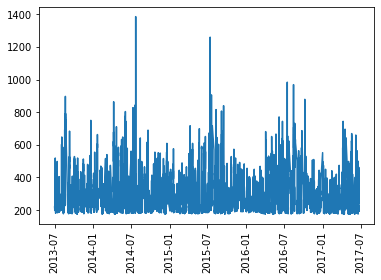

In [ ]:
plt.plot(train_df['datetime'], train_df[target] )
plt.xticks(rotation=90)

Text(0.5, 1.0, '2017')

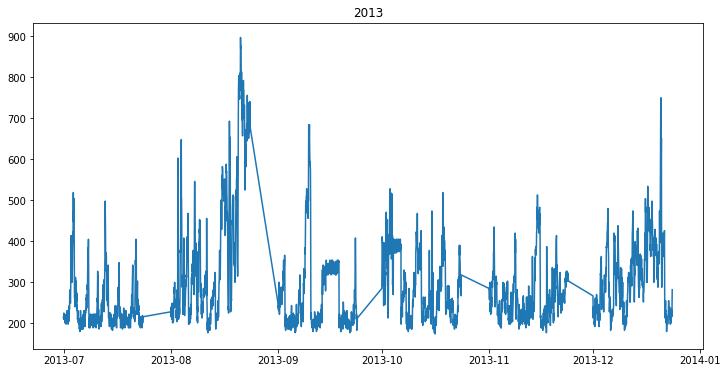

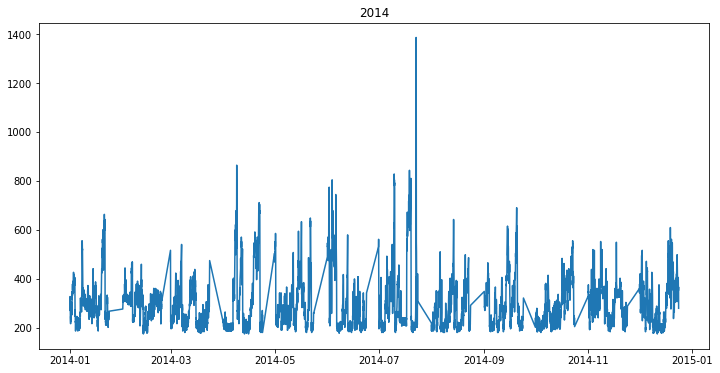

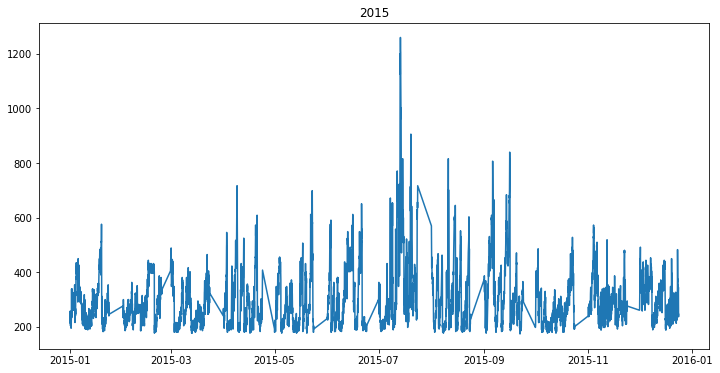

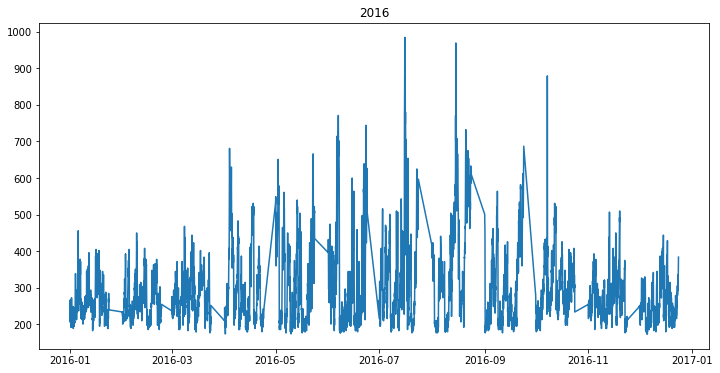

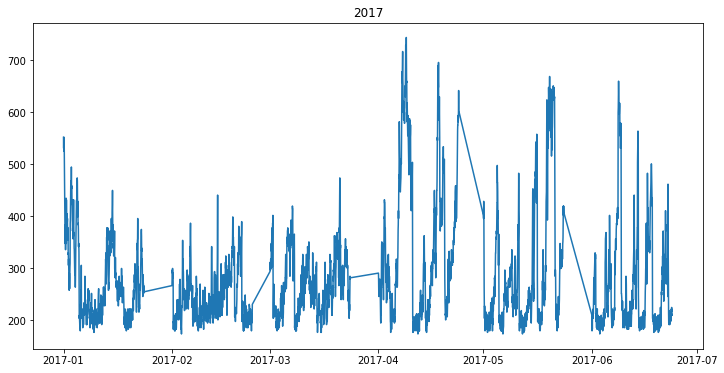

In [ ]:
target = 'electricity_consumption'
plt.figure(figsize=(12,6))
plt.plot(train_df.loc[train_df.datetime.dt.year==2013]['datetime'], train_df.loc[train_df.datetime.dt.year==2013][target])
plt.title('2013')
plt.figure(figsize=(12,6))
plt.plot(train_df.loc[train_df.datetime.dt.year==2014]['datetime'], train_df.loc[train_df.datetime.dt.year==2014][target])
plt.title('2014')
plt.figure(figsize=(12,6))
plt.plot(train_df.loc[train_df.datetime.dt.year==2015]['datetime'], train_df.loc[train_df.datetime.dt.year==2015][target])
plt.title('2015')
plt.figure(figsize=(12,6))
plt.plot(train_df.loc[train_df.datetime.dt.year==2016]['datetime'], train_df.loc[train_df.datetime.dt.year==2016][target])
plt.title('2016')
plt.figure(figsize=(12,6))
plt.plot(train_df.loc[train_df.datetime.dt.year==2017]['datetime'], train_df.loc[train_df.datetime.dt.year==2017][target])
plt.title('2017')

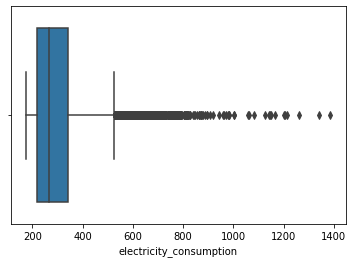

In [ ]:
sns.boxplot(train_df[target])

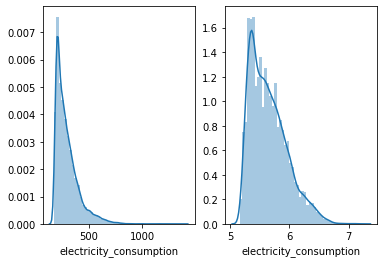

In [ ]:
fig, ax = plt.subplots(1,2)
sns.distplot(train_df[target], ax=ax[0])
sns.distplot(np.log1p(train_df[target]), ax=ax[1])

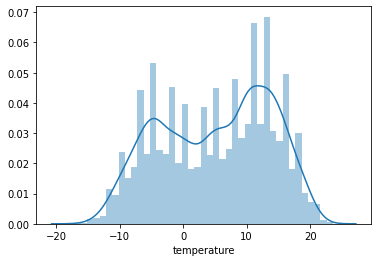

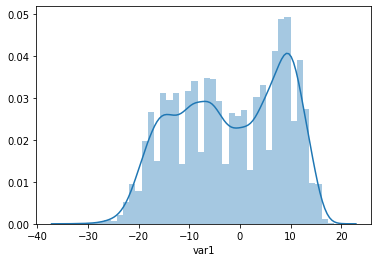

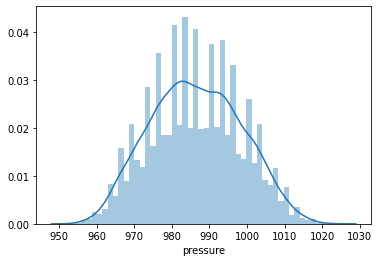

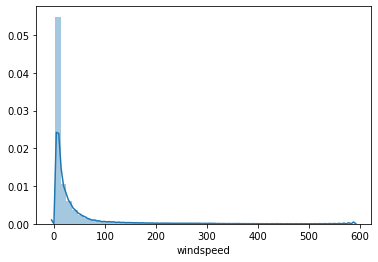

In [ ]:
for col in ['temperature', 'var1', 'pressure', 'windspeed']:
    plt.figure()
    sns.distplot(train_df[col])

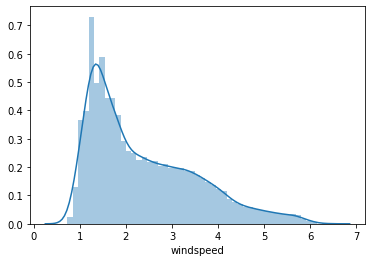

In [ ]:
sns.distplot(np.log1p(train_df['windspeed']) )

array(['A', 'B', 'C'], dtype=object)

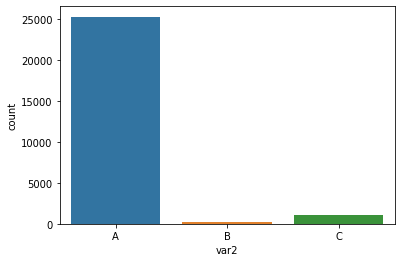

In [ ]:
sns.countplot(train_df['var2'])
train_df['var2'].unique()


In [ ]:
train_df['ID'].nunique()

26496

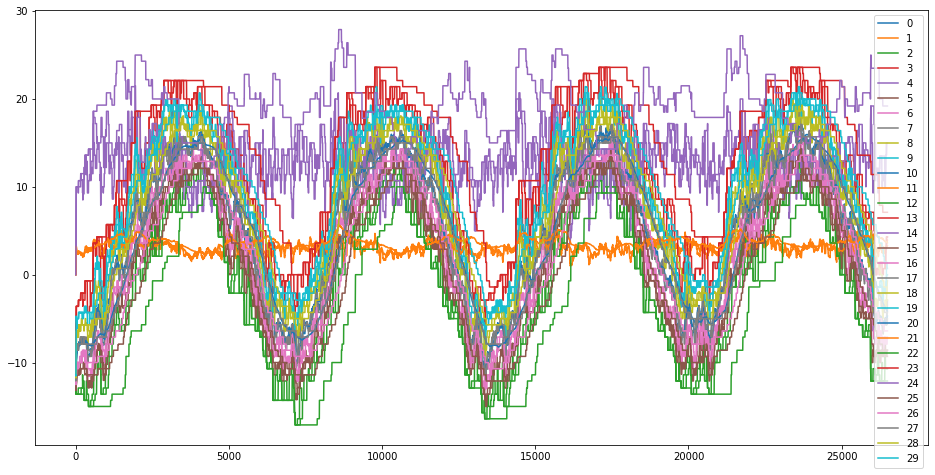

In [ ]:
plt.figure(figsize=(16,8))
# plt.plot(train_df['electricity_consumption'] )
for i in range(30):
    plt.plot(train_stats.iloc[:,i], label=str(i))
    plt.legend()
    # plt.xticks(rotation=90)

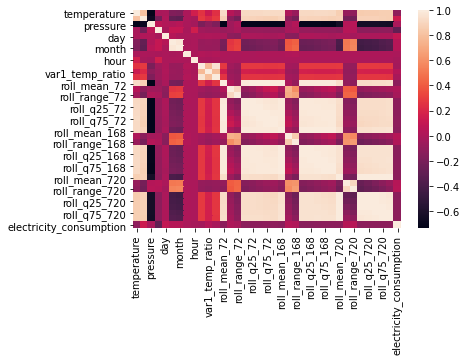

In [ ]:
# correlation Roll stats with target var

# df_stats_cor = pd.concat([train_stats, train_df['electricity_consumption']], axis=1).corr()

df_cor = pd.concat([train[features], train['electricity_consumption']], axis=1).corr()
sns.heatmap(df_cor)

## FE I

In [ ]:
def create_daylag_features(df):

    day_df = df.groupby([df["datetime"].dt.day]).agg({'temperature':'mean',\
                          'pressure':'mean',\
                          'var1':'mean',\
                          'windspeed':'mean',\
                        #   'var2':'nunique',\
                          'electricity_consumption':['sum','mean']}).reset_index()

    day_df['lag_1'] = day_df.groupby(['month','year'])['electricity_consumption_mean'].shift(1)
    day_df['lag_windspeed_mean'] = day_df.groupby(['month','year'])['windspeed_mean'].shift(1)
    day_df['lag_temperature_mean'] = day_df.groupby(['month','year'])['temperature_mean'].shift(1)
    day_df['lag_pressure_mean'] = day_df.groupby(['month','year'])['pressure_mean'].shift(1)
    day_df['lag_var1_mean'] = day_df.groupby(['month','year'])['var1_mean'].shift(1)

    return day_df



In [ ]:
# Add new Features

def create_features(df):
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["day"] = df["datetime"].dt.day
    df["week"] = df["datetime"].dt.week
    df["month"] = df["datetime"].dt.month
    df["day_of_week"] = df["datetime"].dt.dayofweek
    df["hour"] = df["datetime"].dt.hour

    df['windspeed'] = np.log1p(df['windspeed'])

    df['var1_press_ratio'] = df['pressure']/df['var1']
    df['var1_temp_ratio'] = df['temperature']/df['var1']
    df['var1_windspeed_ratio'] = df['windspeed']/df['var1']
    return df

# lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
# window1 = 3
# window2 = 7
# window3 = 30

def create_lag_features(df, lag_features, windows):
    
    df.reset_index(drop=True, inplace=True)
    # df_rolled_3d = df[lag_features].rolling(window=windows[0], min_periods=0)
    # df_rolled_7d = df[lag_features].rolling(window=windows[1], min_periods=0)
    # df_rolled_30d = df[lag_features].rolling(window=windows[2], min_periods=0)

    df_mean_3d = df[lag_features].rolling(window=windows[0], min_periods=0).mean().shift(1).reset_index().astype(np.float32)
    df_mean_7d = df[lag_features].rolling(window=windows[1], min_periods=0).mean().shift(1).reset_index().astype(np.float32)
    df_mean_30d = df[lag_features].rolling(window=windows[2], min_periods=0).mean().shift(1).reset_index().astype(np.float32)

    df_std_3d = df[lag_features].rolling(window=windows[0], min_periods=0).std().shift(1).reset_index().astype(np.float32)
    df_std_7d = df[lag_features].rolling(window=windows[1], min_periods=0).std().shift(1).reset_index().astype(np.float32)
    df_std_30d = df[lag_features].rolling(window=windows[2], min_periods=0).std().shift(1).reset_index().astype(np.float32)

    for feature in lag_features:
        df[f"{feature}_mean_lag{windows[0]}"] = df_mean_3d[feature]
        df[f"{feature}_mean_lag{windows[1]}"] = df_mean_7d[feature]
        df[f"{feature}_mean_lag{windows[2]}"] = df_mean_30d[feature]
        
        df[f"{feature}_std_lag{windows[0]}"] = df_std_3d[feature]
        df[f"{feature}_std_lag{windows[1]}"] = df_std_7d[feature]
        df[f"{feature}_std_lag{windows[2]}"] = df_std_30d[feature]

    df.fillna(df.mean(), inplace=True)
    df.set_index("datetime", drop=False, inplace=True)
    return df

def calc_roll_stats(s, windows=[10, 50, 100]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10)
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25)
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75)
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90)
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [ ]:
# train_stats = calc_roll_stats(train_df.temperature, windows=[3, 7, 30])
train_stats.columns.tolist()

['roll_mean_3',
 'roll_std_3',
 'roll_min_3',
 'roll_max_3',
 'roll_range_3',
 'roll_q10_3',
 'roll_q25_3',
 'roll_q50_3',
 'roll_q75_3',
 'roll_q90_3',
 'roll_mean_7',
 'roll_std_7',
 'roll_min_7',
 'roll_max_7',
 'roll_range_7',
 'roll_q10_7',
 'roll_q25_7',
 'roll_q50_7',
 'roll_q75_7',
 'roll_q90_7',
 'roll_mean_30',
 'roll_std_30',
 'roll_min_30',
 'roll_max_30',
 'roll_range_30',
 'roll_q10_30',
 'roll_q25_30',
 'roll_q50_30',
 'roll_q75_30',
 'roll_q90_30']

In [ ]:

# lag_features = ['temperature']  # 'pressure' , 'windspeed'
windows = [3*24, 7*24, 30*24]

train = create_features(train_df)
# train = create_lag_features(train, lag_features, windows)
train_stats = calc_roll_stats(train.temperature, windows=windows)

train = pd.concat([train, train_stats], axis=1)

train.head(10)

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption,day,week,month,day_of_week,hour,var1_press_ratio,var1_temp_ratio,var1_windspeed_ratio,roll_mean_72,roll_std_72,roll_min_72,roll_max_72,roll_range_72,roll_q10_72,roll_q25_72,roll_q50_72,roll_q75_72,roll_q90_72,roll_mean_168,roll_std_168,roll_min_168,roll_max_168,roll_range_168,roll_q10_168,roll_q25_168,roll_q50_168,roll_q75_168,roll_q90_168,roll_mean_720,roll_std_720,roll_min_720,roll_max_720,roll_range_720,roll_q10_720,roll_q25_720,roll_q50_720,roll_q75_720,roll_q90_720
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,1.994799,A,216.0,1,27,7,0,0,-58.654971,0.666667,-0.116655,-11.400000,0.000000,-11.4,-11.4,0.0,-11.40,-11.400,-11.40,-11.400,-11.40,-11.400000,0.000000,-11.4,-11.4,0.0,-11.40,-11.400,-11.40,-11.400,-11.40,-11.400000,0.000000,-11.4,-11.4,0.0,-11.40,-11.400,-11.40,-11.400,-11.40
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,1.995540,A,210.0,1,27,7,0,1,-51.606218,0.626943,-0.103396,-11.750000,0.494975,-12.1,-11.4,0.7,-12.03,-11.925,-11.75,-11.575,-11.47,-11.750000,0.494975,-12.1,-11.4,0.7,-12.03,-11.925,-11.75,-11.575,-11.47,-11.750000,0.494975,-12.1,-11.4,0.7,-12.03,-11.925,-11.75,-11.575,-11.47
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,1.996339,A,225.0,1,27,7,0,2,-50.000000,0.645000,-0.099817,-12.133333,0.750555,-12.9,-11.4,1.5,-12.74,-12.500,-12.10,-11.750,-11.54,-12.133333,0.750555,-12.9,-11.4,1.5,-12.74,-12.500,-12.10,-11.750,-11.54,-12.133333,0.750555,-12.9,-11.4,1.5,-12.74,-12.500,-12.10,-11.750,-11.54
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,1.997307,A,216.0,1,27,7,0,3,-58.187135,0.666667,-0.116802,-11.950000,0.714143,-12.9,-11.4,1.5,-12.66,-12.300,-11.75,-11.400,-11.40,-11.950000,0.714143,-12.9,-11.4,1.5,-12.66,-12.300,-11.75,-11.400,-11.40,-11.950000,0.714143,-12.9,-11.4,1.5,-12.66,-12.300,-11.75,-11.400,-11.40
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,1.998238,A,222.0,1,27,7,0,4,-52.072539,0.590674,-0.103536,-11.840000,0.665582,-12.9,-11.4,1.5,-12.58,-12.100,-11.40,-11.400,-11.40,-11.840000,0.665582,-12.9,-11.4,1.5,-12.58,-12.100,-11.40,-11.400,-11.40,-11.840000,0.665582,-12.9,-11.4,1.5,-12.58,-12.100,-11.40,-11.400,-11.40
5,5,2013-07-01 05:00:00,-10.7,-19.3,1013.0,0.846883,A,216.0,1,27,7,0,5,-52.487047,0.554404,-0.043880,-11.650000,0.755645,-12.9,-10.7,2.2,-12.50,-11.925,-11.40,-11.400,-11.05,-11.650000,0.755645,-12.9,-10.7,2.2,-12.50,-11.925,-11.40,-11.400,-11.05,-11.650000,0.755645,-12.9,-10.7,2.2,-12.50,-11.925,-11.40,-11.400,-11.05
6,6,2013-07-01 06:00:00,-13.6,-17.1,1006.0,0.986819,A,219.0,1,27,7,0,6,-58.830409,0.795322,-0.057709,-11.928571,1.009479,-13.6,-10.7,2.9,-13.18,-12.500,-11.40,-11.400,-11.12,-11.928571,1.009479,-13.6,-10.7,2.9,-13.18,-12.500,-11.40,-11.400,-11.12,-11.928571,1.009479,-13.6,-10.7,2.9,-13.18,-12.500,-11.40,-11.400,-11.12
7,7,2013-07-01 07:00:00,-11.4,-17.9,997.0,1.149250,A,222.0,1,27,7,0,7,-55.698324,0.636872,-0.064204,-11.862500,0.953096,-13.6,-10.7,2.9,-13.11,-12.300,-11.40,-11.400,-11.19,-11.862500,0.953096,-13.6,-10.7,2.9,-13.11,-12.300,-11.40,-11.400,-11.19,-11.862500,0.953096,-13.6,-10.7,2.9,-13.11,-12.300,-11.40,-11.400,-11.19
8,8,2013-07-01 08:00:00,-10.7,-18.6,1012.0,1.272333,A,219.0,1,27,7,0,8,-54.408602,0.575269,-0.068405,-11.733333,0.972111,-13.6,-10.7,2.9,-13.04,-12.100,-11.40,-11.400,-10.70,-11.733333,0.972111,-13.6,-10.7,2.9,-13.04,-12.100,-11.40,-11.400,-10.70,-11.733333,0.972111,-13.6,-10.7,2.9,-13.04,-12.100,-11.40,-11.400,-10.70
9,9,2013-07-01 09:00:00,-10.0,-16.4,1002.0,1.371973,A,222.0,1,27,7,0,9,-61.097561,0.609756,-0.083657,-11.560000,1.067916,-13.6,-10.0,3.6,-12.97,-11.925,-11.40,-10.875,-10.63,-11.560000,1.067916,-13.6,-10.0,3.6,-12.97,-11.925,-11.40,-10.875,-10.63,-11.560000,1.067916,-13.6,-10.0,3.6,-12.97,-11.925,-11.40,-10.875,-10.63


In [ ]:
target = 'electricity_consumption'

train['target_log'] = np.log1p(train_df[target])

# train_df["var2"] = train_df["var2"].astype('category')

drop_cols = ['ID', 'datetime', 'var2', target, 'target_log',
              'roll_q25_72', 'roll_q50_72','roll_q75_72',
             'roll_q10_72', 'roll_q90_72', 'roll_q10_72'
              'roll_q25_168','roll_q50_168','roll_q75_168',
             'roll_q25_720','roll_q50_720','roll_q75_720',
             'roll_min_72', 'roll_max_72',  'roll_min_720', 'roll_max_720' ,  'roll_min_168', 'roll_max_168'            
             ]

features = [col for col in train.columns if col not in drop_cols]
categorical_feats = ['week', 'month', 'day_of_week']   # 'day'

print('Train with %.f features' % len(features))
print(features)
print()
print(categorical_feats)

Train with 26 features
['temperature', 'var1', 'pressure', 'windspeed', 'day', 'week', 'month', 'day_of_week', 'hour', 'var1_press_ratio', 'var1_temp_ratio', 'var1_windspeed_ratio', 'roll_mean_72', 'roll_std_72', 'roll_range_72', 'roll_mean_168', 'roll_std_168', 'roll_range_168', 'roll_q10_168', 'roll_q25_168', 'roll_q90_168', 'roll_mean_720', 'roll_std_720', 'roll_range_720', 'roll_q10_720', 'roll_q90_720']

['week', 'month', 'day_of_week']


In [ ]:
N_FOLDS = 2
RSTATE = 26
SHUFFLE = False    # True 

TARGET_LOG = False     # False

In [ ]:
if TARGET_LOG:
    target = 'target_log'
else:
    target = 'electricity_consumption'
print('Train with target var: %s' % target)

Train with target var: electricity_consumption


In [ ]:
# train[features].columns.tolist()

features = ['temperature',
 'var1',
#  'pressure',
 'windspeed',
#  'day',
 'week',
 'month',
 'day_of_week',
 'hour',
 'var1_press_ratio',
 'var1_temp_ratio',
 'var1_windspeed_ratio',
#  'roll_mean_72',
#  'roll_range_72',
#  'roll_mean_168',
#  'roll_std_168',
#  'roll_range_168',
#  'roll_q10_168',
#  'roll_q25_168',
#  'roll_q90_168',
#  'roll_mean_720',
#  'roll_std_720',
#  'roll_range_720',
#  'roll_q10_720',
#  'roll_q90_720'
 ]

## LGBM

In [ ]:
# LGBM Model

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 2**8,
    'max_depth':8,
    "learning_rate": 0.01,
    "feature_fraction": 0.95,
    "reg_lambda": 2,
    "metric": "rmse",
}


In [ ]:

# kf = KFold(n_splits=N_FOLDS, shuffle=SHUFFLE, random_state=RSTATE)
kf = GroupKFold(n_splits=N_FOLDS)  

models_lgb = []
scores = []
oof = np.zeros(train.shape[0])

print('Training LGBM with %.f features' % len(features))
for fold, (train_idx, test_idx) in enumerate(kf.split(train[features],  groups=train['datetime'].dt.day), 1):
    train_x = train[features].iloc[train_idx]
    valid_x = train[features].iloc[test_idx]
    train_y = train[target].iloc[train_idx]
    valid_y =  train[target].iloc[test_idx]
    
    d_train = lgb.Dataset(train_x, label=train_y, categorical_feature=categorical_feats, free_raw_data=False)
    d_valid = lgb.Dataset(valid_x, label=valid_y, categorical_feature=categorical_feats, free_raw_data=False)
    
    # LGBM 
    model = lgb.train(params, d_train, num_boost_round=2000, valid_sets=[d_train,d_valid], 
                      verbose_eval=100, early_stopping_rounds=50)
    
    if TARGET_LOG: 
        oof_preds_ = np.expm1(model.predict(valid_x, num_iteration=model.best_iteration))
    else:
        oof_preds_ = model.predict(valid_x, num_iteration=model.best_iteration)

    # # HistGB
    # model = HistGradientBoostingRegressor(learning_rate=0.1, max_iter=600, n_iter_no_change=50, verbose=50, scoring='neg_root_mean_squared_error')
    # model.fit(train_x, train_y)
    # if TARGET_LOG: 
    #     oof_preds_ = np.expm1(model.predict(valid_x))
    # else:
    #     oof_preds_ = model.predict(valid_x)


    oof[test_idx] = oof_preds_

    models_lgb.append(model)
    # imp_df.iloc[:, fold - 1] = model.feature_importance()


    score = np.sqrt(mean_squared_error(valid_y, oof_preds_))
    scores.append(score)
    print('Fold {} RMSLE {}\n'.format(fold, score))

print('Mean RMSLE {} [STD:{}]'.format(np.mean(scores), np.std(scores)))
print('OOF RMSE {}'.format(np.sqrt(mean_squared_error(train[target], oof))))


# Mean RMSLE 0.2292675730830375 [STD:0.012006335086043832]
# OOF RMSE 83.71144319279745

# shuffle = false
# Mean RMSLE 0.23115227902695173 [STD:0.010995971330387332]
# OOF RMSE 83.69533632421415

Training LGBM with 10 features
Training until validation scores don't improve for 50 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 71.8989	valid_1's rmse: 90.2133
[200]	training's rmse: 58.6571	valid_1's rmse: 87.096
[300]	training's rmse: 52.5853	valid_1's rmse: 86.7027
Early stopping, best iteration is:
[271]	training's rmse: 53.9239	valid_1's rmse: 86.6389
Fold 1 RMSLE 86.63893617884273

Training until validation scores don't improve for 50 rounds.


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 75.4189	valid_1's rmse: 83.6197
[200]	training's rmse: 61.6403	valid_1's rmse: 80.3104
Early stopping, best iteration is:
[212]	training's rmse: 60.5685	valid_1's rmse: 80.2828
Fold 2 RMSLE 80.28278223414402

Mean RMSLE 83.46085920649338 [STD:3.178076972349352]
OOF RMSE 83.659308976094


In [ ]:
# from sklearn import metrics
# sorted(metrics.SCORERS.keys())

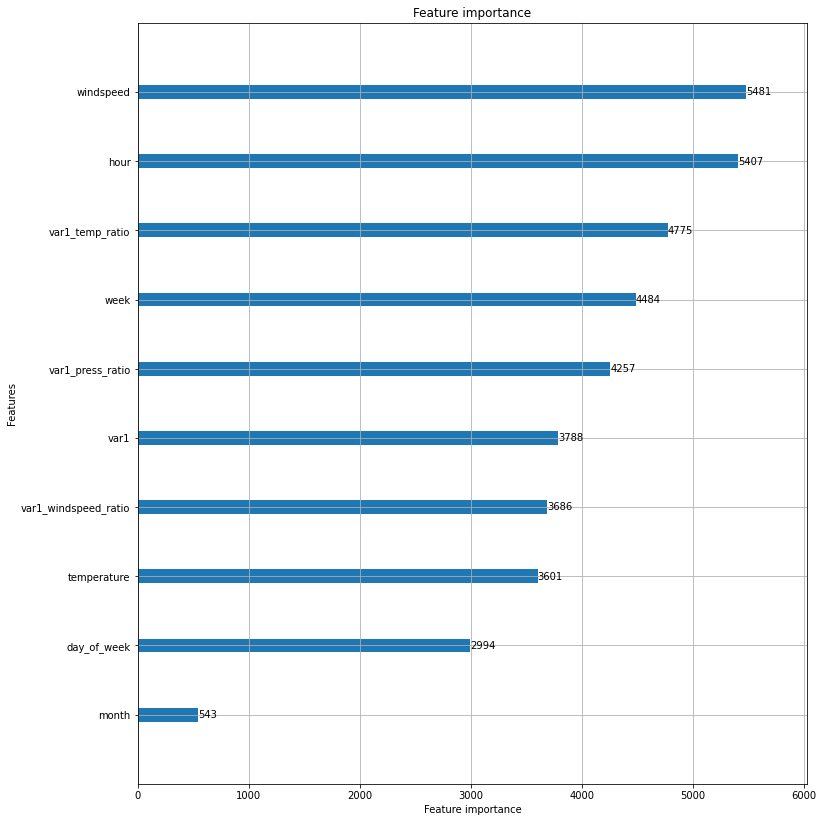

In [ ]:
for model in models_lgb:
    lgb.plot_importance(model, figsize=(12,14))
    plt.show()
    break;

## CatBoost

In [ ]:
params_cb = dict(depth=8, 
                 learning_rate=0.01, 
                 loss_function='RMSE',
                 eval_metric='RMSE',
                 l2_leaf_reg=4,  
                 verbose=50,
                 od_wait=50,
                 use_best_model=True,
                #  max_leaves=16, 
                #  num_leaves=32,
                #  cat_features=categorical_feats
                 )   # early_stopping_rounds=50 

In [ ]:
kf = GroupKFold(n_splits=N_FOLDS)   

models_cb = []
scores = []
oof = np.zeros(train.shape[0])

print('Train CatBoost with %.f features' % len(features) )
for fold, (train_idx, test_idx) in enumerate(kf.split(train[features],  groups=train['datetime'].dt.day), 1):
    train_x = train[features].iloc[train_idx]
    valid_x = train[features].iloc[test_idx]
    train_y = train[target].iloc[train_idx]
    valid_y =  train[target].iloc[test_idx]
    
    d_train = Pool(train_x.values, label=train_y.values, feature_names=features) # cat_features=categorical_feats
    d_valid = Pool(valid_x.values, label=valid_y.values, feature_names=features) # cat_features=categorical_feats
    
    model = cb.train(d_train, params=params_cb, num_boost_round=2000, eval_set=[d_train,d_valid],
                      verbose=100, early_stopping_rounds=50)
    
    if TARGET_LOG: 
        oof_preds_ = np.expm1(model.predict(valid_x))
    else:
        oof_preds_ = model.predict(valid_x)

    oof[test_idx] = oof_preds_

    models_cb.append(model)

    score = np.sqrt(mean_squared_error(valid_y, oof_preds_))
    scores.append(score)
    print('Fold {} RMSE {}\n'.format(fold, score))

print('Mean RMSE {} [STD:{}]'.format(np.mean(scores), np.std(scores)))
print('OOF RMSE {}'.format(np.sqrt(mean_squared_error(train[target], oof))))    # 78.16

Train CatBoost with 10 
0:	learn: 105.3218789	test: 105.3218789	test1: 109.8608950	best: 109.8608950 (0)	total: 9.66ms	remaining: 19.3s
100:	learn: 87.3477498	test: 87.3477498	test1: 92.8768845	best: 92.8768845 (100)	total: 815ms	remaining: 15.3s
200:	learn: 80.4232024	test: 80.4232024	test1: 87.1051857	best: 87.1051857 (200)	total: 1.63s	remaining: 14.6s
300:	learn: 76.8407037	test: 76.8407037	test1: 84.5210276	best: 84.5210276 (300)	total: 2.47s	remaining: 13.9s
400:	learn: 74.1249589	test: 74.1249589	test1: 83.2480615	best: 83.2480615 (400)	total: 3.31s	remaining: 13.2s
500:	learn: 71.8646193	test: 71.8646193	test1: 82.4161512	best: 82.4161314 (499)	total: 4.11s	remaining: 12.3s
600:	learn: 70.0358658	test: 70.0358658	test1: 81.8444141	best: 81.8300921 (597)	total: 4.92s	remaining: 11.5s
700:	learn: 68.5228191	test: 68.5228191	test1: 81.4252042	best: 81.4252042 (700)	total: 5.71s	remaining: 10.6s
800:	learn: 67.1811757	test: 67.1811757	test1: 81.1540014	best: 81.1540014 (800)	total:

In [ ]:
cb_reg = cb.CatBoostRegressor(depth=8, 
                 learning_rate=0.01, 
                 loss_function='RMSE',
                 eval_metric='RMSE',
                 l2_leaf_reg=4,  
                 verbose=200,
                 n_estimators=1000
                #  od_wait=50,
                #  use_best_model=True,
                #  max_leaves=16, 
                #  num_leaves=32,
                #  cat_features=categorical_feats
                )

In [ ]:
cb_reg.fit(train[features], train[target])


0:	learn: 107.6697460	total: 12ms	remaining: 12s
200:	learn: 82.5825498	total: 2.12s	remaining: 8.43s
400:	learn: 77.3199638	total: 4.2s	remaining: 6.27s
600:	learn: 74.2117730	total: 6.33s	remaining: 4.2s
800:	learn: 72.2196220	total: 8.45s	remaining: 2.1s
999:	learn: 70.5619265	total: 10.6s	remaining: 0us


In [ ]:
test_preds_cb = cb_reg.predict(test)

(array([ 350., 1560., 2322., 2017.,  979.,  484.,  417.,  324.,   93.,
          22.]), array([181.47902873, 224.32510309, 267.17117744, 310.0172518 ,
        352.86332616, 395.70940052, 438.55547488, 481.40154923,
        524.24762359, 567.09369795, 609.93977231]), <a list of 10 Patch objects>)

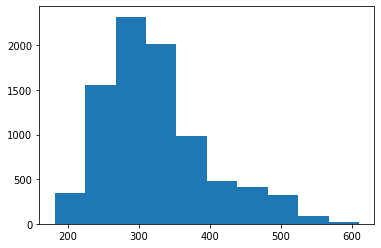

In [ ]:
plt.hist(test_preds_cb)

## CatBoost x 3 Ensemble

In [ ]:

def train_cb(params_cb, n_trees=3000):
    
    kf = GroupKFold(n_splits=4)   
    models_cb = []
    scores = []
    oof = np.zeros(train.shape[0])

    for fold, (train_idx, test_idx) in enumerate(kf.split(train[features],  groups=train['datetime'].dt.day), 1):
        train_x = train[features].iloc[train_idx]
        valid_x = train[features].iloc[test_idx]
        train_y = train[target].iloc[train_idx]
        valid_y =  train[target].iloc[test_idx]
        
        d_train = Pool(train_x.values, label=train_y.values) # categorical_feature=categorical_feats
        d_valid = Pool(valid_x.values, label=valid_y.values) # categorical_feature=categorical_feats
        
        model = cb.train(d_train, params=params_cb, num_boost_round=n_trees, eval_set=[d_train,d_valid],
                        verbose=100, early_stopping_rounds=50)
        
        if TARGET_LOG: 
            oof_preds_ = np.expm1(model.predict(valid_x)) #num_iteration=model.best_iteration_
        else:
            oof_preds_ = model.predict(valid_x)

        oof[test_idx] = oof_preds_

        models_cb.append(model)

        score = np.sqrt(mean_squared_error(valid_y, oof_preds_))
        scores.append(score)
        print('Fold {} RMSLE {}\n'.format(fold, score))

    print('Mean RMSLE {} [STD:{}]'.format(np.mean(scores), np.std(scores)))
    print('OOF RMSE {}'.format(np.sqrt(mean_squared_error(train[target], oof))))

    return models_cb

In [ ]:
# Catboost-1 

params_cb_1 = dict(depth=10, learning_rate=0.01, loss_function='RMSE',eval_metric='RMSE', l2_leaf_reg=5, verbose=50, od_wait=50) 
cb_models_1 = train_cb(params_cb_1, n_trees=3000)


# Catboost-2
params_cb_2 = dict(depth=12, learning_rate=0.01, loss_function='RMSE',eval_metric='RMSE', l2_leaf_reg=5, verbose=50, od_wait=50) 
cb_models_2 = train_cb(params_cb_2, n_trees=3000)

# Catboost-3
params_cb_3 = dict(depth=14, learning_rate=0.02, loss_function='RMSE',eval_metric='RMSE', l2_leaf_reg=5, verbose=50, od_wait=50) 
cb_models_3 = train_cb(params_cb_3, n_trees=3000)

0:	learn: 103.1182633	test: 103.1182633	test1: 119.8207530	best: 119.8207530 (0)	total: 68.9ms	remaining: 3m 26s
100:	learn: 83.7237994	test: 83.7237994	test1: 100.3896111	best: 100.3896111 (100)	total: 1.61s	remaining: 46.2s
200:	learn: 75.8909758	test: 75.8909758	test1: 93.7033000	best: 93.7033000 (200)	total: 3.09s	remaining: 43s
300:	learn: 71.3073082	test: 71.3073082	test1: 90.5580173	best: 90.5580173 (300)	total: 4.6s	remaining: 41.2s
400:	learn: 67.9927456	test: 67.9927456	test1: 88.9019229	best: 88.9019229 (400)	total: 6.08s	remaining: 39.4s
500:	learn: 65.2595837	test: 65.2595837	test1: 87.7294791	best: 87.7294791 (500)	total: 7.59s	remaining: 37.9s
600:	learn: 62.9619879	test: 62.9619879	test1: 86.9044155	best: 86.8990755 (599)	total: 9.08s	remaining: 36.3s
700:	learn: 60.9445387	test: 60.9445387	test1: 86.4589574	best: 86.4589574 (700)	total: 10.6s	remaining: 34.8s
800:	learn: 59.1463819	test: 59.1463819	test1: 86.0465314	best: 86.0465314 (800)	total: 12.1s	remaining: 33.3s


## XGB

In [ ]:
import xgboost as xgb
from xgboost import DMatrix, XGBRegressor

In [ ]:
params_xgb = {'min_child_weight': 5, 
          'colsample_bytree': 0.7, 
          'max_depth': 11,
          'subsample': 0.8, 
          'lambda': 2, 
          'nthread': -1, 
          'booster':'gbtree', 
          'silent': 1, 
        #   'gamma' : 0,
          'eval_metric': 'rmse', 
          'objective': 'reg:squarederror'}

In [ ]:
kf = GroupKFold(n_splits=4)   

models_xgb = []
scores = []
oof = np.zeros(train.shape[0])

for fold, (train_idx, test_idx) in enumerate(kf.split(train[features],  groups=train['datetime'].dt.day), 1):
    train_x = train[features].iloc[train_idx]
    valid_x = train[features].iloc[test_idx]
    train_y = train[target].iloc[train_idx]
    valid_y =  train[target].iloc[test_idx]
    
    d_train = xgb.DMatrix(train_x.values, label=train_y.values, feature_names=features) # categorical_feature=categorical_feats
    d_valid = xgb.DMatrix(valid_x.values, label=valid_y.values, feature_names=features) # categorical_feature=categorical_feats
    
    # LGBM 
    model = xgb.train(params_xgb, d_train, num_boost_round=2000, 
                      evals=[(d_train,'train'), (d_valid,'valid')],
                      verbose_eval=100, early_stopping_rounds=50)
    
    if TARGET_LOG: 
        oof_preds_ = np.expm1(model.predict(d_valid), ntree_limit=model.best_iteration)
    else:
        oof_preds_ = model.predict(d_valid, ntree_limit=model.best_iteration)

    oof[test_idx] = oof_preds_

    models_xgb.append(model)

    score = np.sqrt(mean_squared_error(valid_y, oof_preds_))
    scores.append(score)
    print('Fold {} RMSLE {}\n'.format(fold, score))

print('Mean RMSLE {} [STD:{}]'.format(np.mean(scores), np.std(scores)))
print('OOF RMSE {}'.format(np.sqrt(mean_squared_error(train[target], oof))))
 
 
 
 

[0]	train-rmse:225.949	valid-rmse:243.543
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[14]	train-rmse:38.1337	valid-rmse:88.2019

Fold 1 RMSLE 88.37932042931108

[0]	train-rmse:231.443	valid-rmse:224.129
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[9]	train-rmse:51.1592	valid-rmse:79.3946

Fold 2 RMSLE 79.94667887401498

[0]	train-rmse:232.355	valid-rmse:221.879
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[9]	train-rmse:50.9876	valid-rmse:76.5747

Fold 3 RMSLE 76.8348830882

[0]	train-rmse:229.043	valid-rmse:232.566
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train

## NN

In [ ]:
del x_train, x_valid, y_train, y_valid
gc.collect()

1215

In [ ]:
x_train = train[train.datetime.dt.year<=2016][features]    # .shape[0], 
x_valid = train[train.datetime.dt.year>2016][features]     # .shape[0]

y_train = train[train.datetime.dt.year<=2016][target]
y_valid = train[train.datetime.dt.year>2016][target]

# print('Training samples %s - years: %s' % (x_train.shape[0], x_train.datetime.dt.year.unique()))
# print('Valid samples %s - years: %s' % (x_valid.shape[0], x_valid.datetime.dt.year.unique()))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

def rmse_keras(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def build_mlp():
    
    inp = Input(shape=x_train.shape[1])
    x = Dense(150, activation='relu')(inp)
    x = Dense(150, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    out = Dense(1, activation='linear')(x)
    model = tf.keras.models.Model(inputs=inp, outputs=out)

    model.compile(optimizer='adam', loss='mse', metrics=[rmse_keras])
    return model


model_nn = build_mlp()
print(model_nn.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 150)               1500      
_________________________________________________________________
dense_22 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               19328     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528 

In [ ]:
callbacks = [
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=1),
             EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)]

In [ ]:
# fit
hist = model_nn.fit(x_train, y_train, 
                    epochs=30, 
                    batch_size=128, 
                    validation_data=(x_valid, y_valid),
                    callbacks=callbacks,
                    shuffle=True,
                    class_weight=None)

Epoch 1/30
182/182 [==============================] - 1s 5ms/step - loss: 13887.9385 - rmse_keras: 86.5507 - val_loss: 10987.9941 - val_rmse_keras: 83.1253 - lr: 0.0010
Epoch 2/30
182/182 [==============================] - 1s 4ms/step - loss: 11534.0430 - rmse_keras: 79.1531 - val_loss: 11045.1494 - val_rmse_keras: 85.9962 - lr: 0.0010
Epoch 3/30
182/182 [==============================] - 1s 4ms/step - loss: 10793.2754 - rmse_keras: 76.0123 - val_loss: 9026.2402 - val_rmse_keras: 74.4156 - lr: 0.0010
Epoch 4/30
182/182 [==============================] - 1s 3ms/step - loss: 9560.8721 - rmse_keras: 70.2154 - val_loss: 9659.1045 - val_rmse_keras: 82.2602 - lr: 0.0010
Epoch 5/30
182/182 [==============================] - 1s 4ms/step - loss: 9310.2930 - rmse_keras: 69.4634 - val_loss: 8142.3013 - val_rmse_keras: 70.9954 - lr: 0.0010
Epoch 6/30
182/182 [==============================] - 1s 4ms/step - loss: 9050.3076 - rmse_keras: 68.3252 - val_loss: 7997.0908 - val_rmse_keras: 59.2705 - lr: 

In [ ]:
hist_df = pd.DataFrame(hist.history)

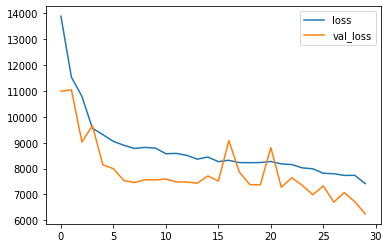

In [ ]:
hist_df[['loss', 'val_loss']].plot()

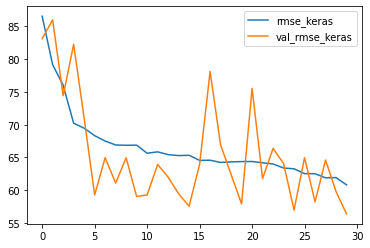

In [ ]:
hist_df[['rmse_keras', 'val_rmse_keras']].plot()

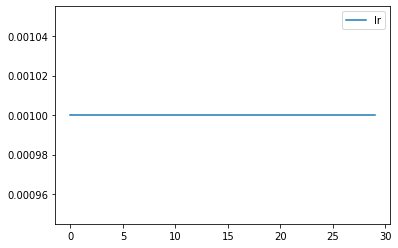

In [ ]:
hist_df[['lr']].plot()

In [ ]:
val_preds_nn = model_nn.predict(x_valid)

print('NN CV RMSE score:', np.sqrt(mean_squared_error(y_valid, val_preds_nn)) )

NN CV RMSE score: 79.14490328671376


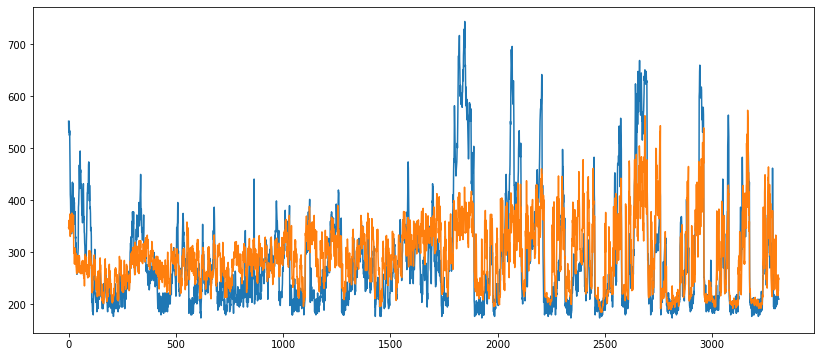

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_valid.values, label='true')
plt.plot(val_preds_nn, label='preds')

In [ ]:
model_nn = build_mlp()

In [ ]:
# NN with GroupKFold

kf = GroupKFold(n_splits=4)   

models_nn = []
histories = []
scores = []
oof = np.zeros(train.shape[0])

for fold, (train_idx, test_idx) in enumerate(kf.split(train[features],  groups=train['datetime'].dt.day), 1):
    train_x = train[features].iloc[train_idx]
    valid_x = train[features].iloc[test_idx]
    train_y = train[target].iloc[train_idx]
    valid_y =  train[target].iloc[test_idx]
      
    # NN
    model_nn = build_mlp()

    hist = model_nn.fit(train_x, train_y, 
                    epochs=100, 
                    batch_size=128, 
                    validation_data=(valid_x, valid_y),
                    callbacks=callbacks,
                    shuffle=True)


    if TARGET_LOG: 
        oof_preds_ = np.expm1(model_nn.predict(valid_x))
    else:
        oof_preds_ = model_nn.predict(valid_x)

    oof[test_idx] = oof_preds_.reshape(-1)

    models_nn.append(model_nn)
    histories.append(hist)

    score = np.sqrt(mean_squared_error(valid_y, oof_preds_.reshape(-1)))
    scores.append(score)
    print('Fold {} RMSLE {}\n'.format(fold, score))

print('Mean RMSLE {} [STD:{}]'.format(np.mean(scores), np.std(scores)))
print('OOF RMSE {}'.format(np.sqrt(mean_squared_error(train[target], oof))))

Epoch 1/100
153/153 [==============================] - 1s 4ms/step - loss: 13354.0996 - rmse_keras: 84.5856 - val_loss: 14338.2041 - val_rmse_keras: 86.9610 - lr: 0.0010
Epoch 2/100
153/153 [==============================] - 1s 4ms/step - loss: 10540.4141 - rmse_keras: 75.4537 - val_loss: 13783.7373 - val_rmse_keras: 88.6508 - lr: 0.0010
Epoch 3/100
153/153 [==============================] - 1s 4ms/step - loss: 10074.9502 - rmse_keras: 73.4790 - val_loss: 13039.5898 - val_rmse_keras: 88.7737 - lr: 0.0010
Epoch 4/100
153/153 [==============================] - 1s 4ms/step - loss: 9014.0459 - rmse_keras: 68.1867 - val_loss: 11413.6807 - val_rmse_keras: 78.1188 - lr: 0.0010
Epoch 5/100
153/153 [==============================] - 1s 4ms/step - loss: 8596.1523 - rmse_keras: 66.2751 - val_loss: 11284.6621 - val_rmse_keras: 74.4510 - lr: 0.0010
Epoch 6/100
153/153 [==============================] - 1s 4ms/step - loss: 8219.8174 - rmse_keras: 64.4761 - val_loss: 10908.7324 - val_rmse_keras: 76.8

In [ ]:
models_nn

## Stacking

In [ ]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Ridge, Lasso

In [ ]:
# LGBM Regressor
lgbm = lgb.LGBMRegressor(objective='regression', 
                         n_estimators=800,
                         learning_rate=0.02, 
                         max_depth=8,
                        num_leaves=2**8,
                        feature_fraction=0.85, 
                        bagging_fraction=0.9, 
                        reg_lambda= 2,
                        #  bagging_freq=5
                         ) 


ridge = Ridge(alpha=0.3)
lasso = Lasso(alpha=0.3)

In [ ]:

kf = KFold(n_splits=2, shuffle=False, random_state=RSTATE)

models_stack = []
scores = []
for idx, (train_idx, val_idx) in enumerate(kf.split(train[features])):
    
    train_x, train_y = train[features].iloc[train_idx], train[target].iloc[train_idx]
    val_x, val_y = train[features].iloc[val_idx], train[target].iloc[val_idx]
    
    model = StackingRegressor(regressors=(lgbm, ridge, lasso),
                              meta_regressor=lgbm, 
                              use_features_in_secondary=True)

    model.fit(train_x.values, train_y.values)
    models_stack.append(model)

    score = np.sqrt(mean_squared_error(val_y, model.predict(np.array(val_x))))
    scores.append(score)
    print('RMSE: {:.4f} of fold: {}'.format(score, idx))

    del train_x, train_y, val_x, val_y; 
    gc.collect()

RMSE: 81.3471 of fold: 0
RMSE: 90.6768 of fold: 1
RMSE: 90.8207 of fold: 2
RMSE: 81.7217 of fold: 3


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173493.64930057526, tolerance: 26036.528102363576
  positive)


RMSE: 73.2431 of fold: 4


## Predict Test set

In [ ]:
# prepare test set
test = create_features(test_df)
# test = create_lag_features(test, lag_features, windows)

test_stats = calc_roll_stats(test.temperature, windows=windows)

test = pd.concat([test, test_stats], axis=1)

print(test[features].shape)
test = test[features].copy()

(8568, 12)


In [ ]:
models_cb


In [ ]:
# KFold Inference
preds_cb = []
for model in models_cb:
    if  preds_cb == []:
        preds_cb = model.predict(test) / len(models_cb)
    else:
        preds_cb += model.predict(test) / len(models_cb)


# results = []
# if TARGET_LOG:
#     for model in models:
#         if  results == []:
#             results = np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
#         else:
#             results += np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
# else:
#     for model in models:
#         if  results == []:
#             results = model.predict(test, num_iteration=model.best_iteration) / len(models)
#         else:
#             results += model.predict(test, num_iteration=model.best_iteration) / len(models)

# # Catboost Ensemble
# preds_cb_1, preds_cb_2, preds_cb_3 = [], [], []

# for model in cb_models_1:
#     if  preds_cb_1 == []:
#         preds_cb_1 = model.predict(test) / len(cb_models_1)
#     else:
#         preds_cb_1 += model.predict(test) / len(cb_models_1)

# for model in cb_models_2:
#     if  preds_cb_2 == []:
#         preds_cb_2 = model.predict(test) / len(cb_models_2)
#     else:
#         preds_cb_2 += model.predict(test) / len(cb_models_2)

# for model in cb_models_3:
#     if  preds_cb_3 == []:
#         preds_cb_3 = model.predict(test) / len(cb_models_3)
#     else:
#         preds_cb_3 += model.predict(test) / len(cb_models_3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# preds_nn = model_nn.predict(test)
preds_nn =[]
for model in models_nn:
    if  preds_nn == []:
        preds_nn = model.predict(test) / len(models_nn)
    else:
        preds_nn += model.predict(test) / len(models_nn)

preds_nn.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


(8568, 1)

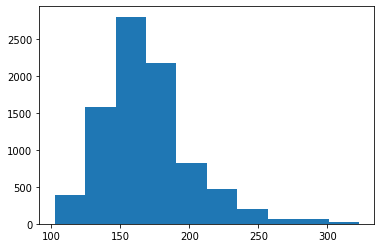

In [ ]:
# plt.hist(preds_nn);
plt.hist(preds_cb2);

In [ ]:
pd.concat([pd.Series(preds_cb_1), pd.Series(preds_cb_2), pd.Series(preds_cb_3)], axis=1).corr()

,0,1,2
0,1.000000,0.997099,0.989044
1,0.997099,1.000000,0.996182
2,0.989044,0.996182,1.000000


(8568,)


(array([ 512., 2186., 2473., 1435.,  704.,  472.,  304.,  312.,  141.,
          29.]), array([200.00532309, 244.06059145, 288.11585982, 332.17112819,
        376.22639656, 420.28166493, 464.33693329, 508.39220166,
        552.44747003, 596.5027384 , 640.55800676]), <a list of 10 Patch objects>)

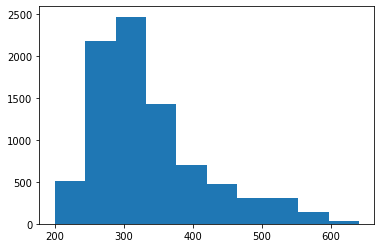

In [ ]:
preds_cb_all = (preds_cb_1 + preds_cb_2 + preds_cb_3)/3

print(preds_cb_all.shape)

plt.hist(preds_cb_all)

### Predict Ensemble

In [ ]:
val_preds_cb = []
for model in cb_models_1:
    if  val_preds_cb == []:
        val_preds_cb = model.predict(x_valid) / len(cb_models_1)
    else:
        val_preds_cb += model.predict(x_valid) / len(cb_models_1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# find optimal weights --- TODO: make a function

from tqdm import tqdm

def find_ensemble_weights(pred1, pred2, plot=False):

    scores = []
    alphas = np.linspace(0,1,101)  # 101

    # loop for every alpha
    for alpha in tqdm(alphas):
        rmse_ = np.sqrt(mean_squared_error(y_valid, alpha*pred1 + (1 - alpha)*pred2))
        scores.append(rmse_)

    # convert to numpy array
    scores = np.array(scores)

    # get best_alpha
    best_alpha = alphas[np.argmin(scores)]

    print()
    print('best_rmse=', scores.min())
    print('best_alpha weight=', best_alpha)

    if plot: 
        plt.plot(alphas, scores)
        plt.title('rmse_score for ensemble')
        plt.xlabel('alpha')
        plt.ylabel('rmse_score')

    return best_alpha


100%|██████████| 101/101 [00:00<00:00, 2246.05it/s]


best_rmse= 55.79027637443703
best_alpha weight= 1.0


1.0

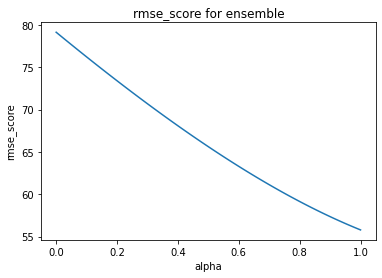

In [ ]:
find_ensemble_weights(val_preds_cb, val_preds_nn.reshape(-1), plot=True)

In [ ]:
# Catboost preds
preds_cb = []
for model in models_cb:
    if  preds_cb == []:
        preds_cb = model.predict(test) / len(models_cb)
    else:
        preds_cb += model.predict(test) / len(models_cb)

preds_lgb = []
for model in models:
        if  preds_lgb == []:
            preds_lgb = model.predict(test, num_iteration=model.best_iteration) / len(models)
        else:
            preds_lgb += model.predict(test, num_iteration=model.best_iteration) / len(models)


preds_cb.shape, preds_lgb.shape

          0         1
0  1.000000  0.778849
1  0.778849  1.000000


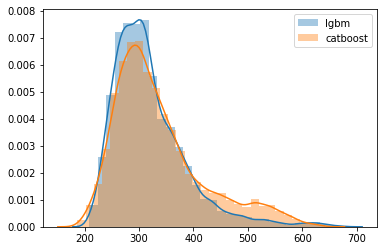

In [ ]:
# check correlation of predictions

cor_df = pd.concat([pd.Series(preds_lgb), pd.Series(preds_cb)], axis=1).corr()
print(cor_df)

plt.figure()
sns.distplot(preds_lgb, label='lgbm', bins=30)
sns.distplot(preds_cb, label='catboost', bins=30)
plt.legend()

In [ ]:
# blend preds

w1 = 0.7

preds = w1*preds_cb + (1-w1)*preds_lgb

preds.shape

(8568,)

## Submission

In [ ]:
subm['electricity_consumption'] = test_preds_cb
subm.to_csv("submission_CB_FE3_9f_all_data4.csv", index=False)      

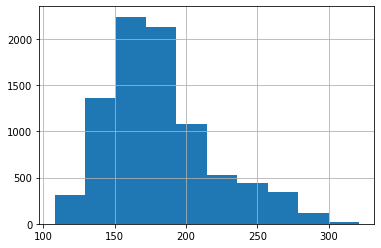

In [ ]:
subm['electricity_consumption'].hist()